<a href="https://colab.research.google.com/github/rage-against-the-machine-learning/cs7643-DL-Group-Project/blob/faiss_resnet18/notebooks/resnet18_faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Resnet-18 with FAISS and Precision/Recall calculations

In [ ]:
from google.colab.output import eval_js
def shrink(height="300"):
    eval_js(f'google.colab.output.setIframeHeight({height})')

Get the data - only need to run once

In [ ]:
numpy_data_path = "/content/drive/MyDrive/numpy_images"

Set up environment

In [ ]:
! pip install --upgrade pip
! pip install torch torchvision torchsummary gca pandas numpy matplotlib seaborn scikit-learn==0.23.2 pycocotools tqdm umap-learn kneed
! pip install git+https://github.com/waleedka/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI
# TODO: install the docem python package via github
! pip list
shrink()

     |████████████████████████████████| 1.6 MB 12.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 6.8 MB 12.7 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 1.1 MB 39.2 MB/s 
  Created wheel for gca: filename=gca-0.1-py3-none-any.whl size=12304 sha256=8ab0191b0139590acc1f8ae6e6db60e60ab813c180537c20bacc15712b85114d
  Stored in directory: /root/.cache/pip/wheels/68/85/d1/f5ac3c697ed91a030ee4b8b4055ebc9f4335b6185f9064609a
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=b8d3c4dcf6656a6c4ca6fac30bc226a4220c9ea53420d0c43fac64e8636acc01
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=8732b0d275d1d8c7b8

Choose a GPU runtime

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    
device

0
1
Tesla K80


device(type='cuda', index=0)

In [ ]:
import os
import multiprocessing as mp
import random
import sys

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import torch 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
import os
import json
print(os.getcwd())

os.chdir("/content/drive/MyDrive/numpy_images/")
print(os.listdir())

embeddings_path = "mini-resnet18_embeddings.pt"
mapping_path = "mini-resnet18_embeddings-v2.json"
embeddings = torch.load(embeddings_path,map_location=torch.device('cpu'))

with open(mapping_path, 'r') as fp:
    idx2Img = json.load(fp)
    
idx2Img = dict(zip(list(map(int, idx2Img.keys())), list(idx2Img.values())))
print(idx2Img)


/content
['data', 'annotations', 'resnext_embeddings.json', 'resnext_embeddings.pt', 'mini-resnet18_embeddings-v2.json', 'mini-resnet18_embeddings.pt']
{0: 184613, 1: 397133, 2: 574769, 3: 374628, 4: 328757, 5: 293802, 6: 37777, 7: 384553, 8: 368402, 9: 87038, 10: 515289, 11: 562150, 12: 173350, 13: 383445, 14: 565797, 15: 394892, 16: 310391, 17: 241876, 18: 462341, 19: 122851, 20: 138246, 21: 197254, 22: 37675, 23: 296649, 24: 19358, 25: 184791, 26: 74331, 27: 579664, 28: 452684, 29: 527040, 30: 350341, 31: 281533, 32: 289393, 33: 281221, 34: 354533, 35: 181666, 36: 545959, 37: 511058, 38: 91227, 39: 334321, 40: 207797, 41: 179558, 42: 15085, 43: 467522, 44: 40102, 45: 403020, 46: 6005, 47: 402559, 48: 189550, 49: 505440, 50: 241691, 51: 290570, 52: 28758, 53: 163020, 54: 281455, 55: 17756, 56: 155885, 57: 231408, 58: 305821, 59: 190056, 60: 121041, 61: 156397, 62: 173574, 63: 208589, 64: 267571, 65: 73830, 66: 82258, 67: 95022, 68: 153299, 69: 216482, 70: 8665, 71: 573291, 72: 161470

In [ ]:
# Img Ids to query
random.seed(10)
#TODO: Madhuri
#Commenting this out so that same images (as in Michael's) can be used for results
#query_images = random.sample(list(idx2Img.values()), 10)
query_images = [100582, 38210, 495291]

print(query_images)
# Position of query images in embedding space
query_idxs = [key for key, value in idx2Img.items() if idx2Img[key] in query_images]

print("query image ids: ", query_images)
print("query image idxs: ", query_idxs)

[100582, 38210, 495291]
query image ids:  [100582, 38210, 495291]
query image idxs:  [1059, 6716, 18611]


In [ ]:

# Update based on the location in your system
annot_file = "annotations/instances_val2014.json"


In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 89.7 MB 5.3 kB/s 


In [ ]:
print(embeddings.shape)
em_np = embeddings.cpu().numpy()
print(type(em_np))

torch.Size([20874, 25088])
<class 'numpy.ndarray'>


In [ ]:
print(em_np.shape)

(20874, 25088)


In [ ]:
query_embedding = em_np[query_idxs]
print(query_embedding.shape)

(3, 25088)


In [ ]:
import faiss
index = faiss.IndexFlatL2(embeddings.shape[1])   # build the index
print(index.is_trained)
index.train(em_np)
index.add(em_np)                  # add vectors to the index
print(index.ntotal)

True
20874


In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import numpy as np
import itertools
from pycocotools.coco import COCO
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import pandas as pd

class EmbeddingPlotter:
    def __init__(self, annot_file, embeddings, idx2Img):
        self.annot_file = annot_file
        self.coco = COCO(self.annot_file)
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.cat_id_to_name_dict = {cat['id']: cat['name'] for cat in cats}
        self.img_ids = list(idx2Img.values())
        self.annIds = self.coco.getAnnIds(self.img_ids)
        #self.labels = [self.coco.loadAnns(self.annIds)]
        
        
        
        
        self.embeddings = embeddings
        self.idx2Img = idx2Img
        self.labels = []
        for k, v in self.idx2Img.items():
            ann_ids_to_append = self.coco.getAnnIds(self.idx2Img[k])
            anns_to_append = self.coco.loadAnns(ann_ids_to_append)
            self.labels.append(anns_to_append)
            
        
        self.category_labels=[]
        # self.category_multi_labels = []
        # self.category_multi_labels_counts = []
        self.supercategory_labels = []
        # self.supercategory_multi_labels = []
        # self.supercategory_multi_labels_counts = []
        
        
 
        
        cats_dict = {cat['id']: cat for cat in cats}
        for label in self.labels:
            
            if len(label) > 0:
                categories = []
                supercategories = []
                
                for annotation in label:
                    categories.append(cats_dict[annotation['category_id']]['name'])
                    supercategories.append(cats_dict[annotation['category_id']]['supercategory'])
                # self.category_multi_labels_counts.append(categories)
                # self.category_multi_labels.append(list(set(categories)))
                # self.supercategory_multi_labels.append(list(set(supercategories)))
                # self.supercategory_multi_labels_counts.append(supercategories)
        
                # most common category among objects in the picture
                category, _ = Counter(categories).most_common(1)[0]
                supercategory, _ = Counter(supercategories).most_common(1)[0]
                
                self.category_labels.append(category)
                self.supercategory_labels.append(supercategory)
            else:
                # self.supercategory_multi_labels.append([])
                # self.supercategory_multi_labels_counts.append([])
                # self.category_multi_labels.append([])
                # self.category_multi_labels_counts.append([])
                self.category_labels.append(None)
                self.supercategory_labels.append(None)
        
    def plot_coco_images(self, img_ids, show_labels=True,
                         show_annotations=False, title_suffix=None, figtitle=None):
        coco = self.coco
        cat_id_to_name_dict = self.cat_id_to_name_dict
        nrows = len(img_ids)
        ncols = len(img_ids[0])
    
        fig = plt.figure(figsize=(ncols*6, nrows*6))
    
        for i, img_id in enumerate(itertools.chain(*img_ids)):
            ax = fig.add_subplot(nrows, ncols, i+1)
            img = coco.loadImgs(img_id)[0]
            I = io.imread(img['coco_url'])
    
            ax.imshow(I, aspect='equal', )
            ax.axis('off')
            
            if title_suffix is not None:
                title=f'{img_id}: {title_suffix[i//nrows, i%ncols]}'
            else:
                title = str(img_id)
            ax.set_title(title)
    
        
            annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
            anns = coco.loadAnns(annIds)
            if show_annotations:
                coco.showAnns(anns)
    
            if show_labels:
                for ann in anns:
                    [x, y, _, _] = ann['bbox']
                    label = cat_id_to_name_dict[ann['category_id']]
    
                    t=ax.annotate(label, (x,y), fontsize=12)
                    t.set_bbox(dict(facecolor='white', alpha=0.2, edgecolor='white'))
    
        plt.tight_layout()
        
        if figtitle:
            fig.suptitle(figtitle)
            plt.subplots_adjust(top=0.90)
        plt.show()
        
    def plot_neighbors(self, X_idx, nbrs, show_annotations=False):
        idx2Img = self.idx2Img
        embeddings = self.embeddings
        m, n = np.shape(embeddings)
        img_id = idx2Img[X_idx]
        
        distances, indices = nbrs.kneighbors(embeddings[X_idx, :].reshape(1, n), 16)
        distances, indices = distances[0], indices[0]
        neighbors_ids = np.array(list(map(idx2Img.get, indices)))
        np.insert(neighbors_ids, 0, img_id)
        np.insert(distances, 0, 0)
        
        title_suffix = np.array([f'distance={distance:.2f}' for distance in distances])
        figtitle=f'Neighbors of {img_id}'
        self.plot_coco_images(neighbors_ids.reshape(4, 4).tolist(), 
                         title_suffix=title_suffix.reshape(4,4),
                         show_annotations=show_annotations,
                         figtitle=figtitle)
        
    def plot_3d(self, X, title=None, columns=['x0', 'x1', 'x2'], **kwargs):
        labels = self.supercategory_labels
        
        
        
        df = pd.DataFrame(X, columns=columns)
        df['label'] = labels
        cmap = plt.get_cmap('gist_rainbow')
        unique_labels = list(set(labels))
        labels_dict = {label: i for i, label in enumerate(unique_labels)}
        num_colors = len(unique_labels)
        c = [cmap(1.*labels_dict[label]/num_colors) for label in labels]
    
        df['c'] = c
        df = df[~df['label'].isna()]
        ax = plt.figure(figsize=(16,10)).gca(projection='3d')
        
        for label, grp in df.groupby('label'):
            ax.scatter(
            xs=grp[columns[0]], 
            ys=grp[columns[1]], 
            zs=grp[columns[2]], 
            c=grp['c'], 
            label=label,
            **kwargs
        #     cmap='gist_rainbow'
        )
        
        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])
        
        plt.legend(loc='best')
        if title:
            plt.title(title)
        plt.show()

In [ ]:
plotter = EmbeddingPlotter(annot_file = annot_file, embeddings=embeddings, idx2Img=idx2Img)

loading annotations into memory...
Done (t=10.73s)
creating index...
index created!


In [ ]:
k = 11                         # we want to see 5 nearest neighbors
D, I = index.search(query_embedding, k) # sanity check
print(I)
print(D)

[[ 1059 11154 15395 11146 15941 18953 13553 12762 17512 19385 20732]
 [ 6716  6408 20848     5 10732  3353 16486  2017  5669  9968  2655]
 [18611 17221  9865  5520 12421 16726 13333 18180 20141 18744 16447]]
[[ 0.        27.26822   42.282467  45.474434  47.24024   56.6961
  57.783165  61.024048  62.06501   62.822395  63.394768 ]
 [ 0.         2.9520807  3.1049833  3.3012486  3.4277196  3.8152375
   3.969976   4.0719757  4.1261296  4.321377   4.38712  ]
 [ 0.         1.3012632  1.311552   1.3861407  1.3936749  1.4080377
   1.4224509  1.4786708  1.5001564  1.5323188  1.5327871]]


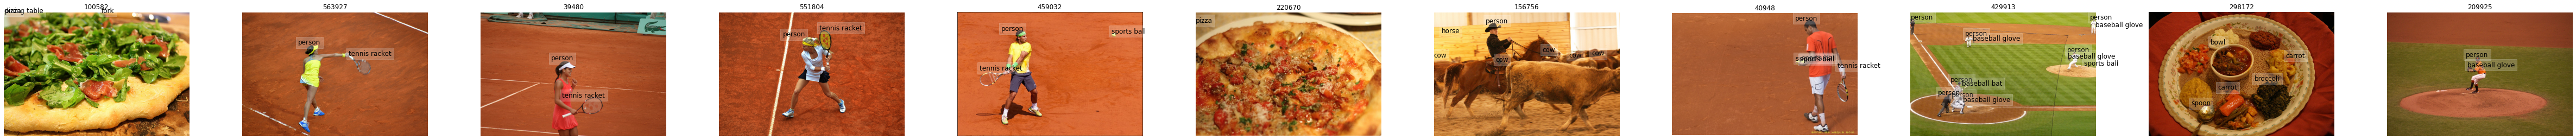

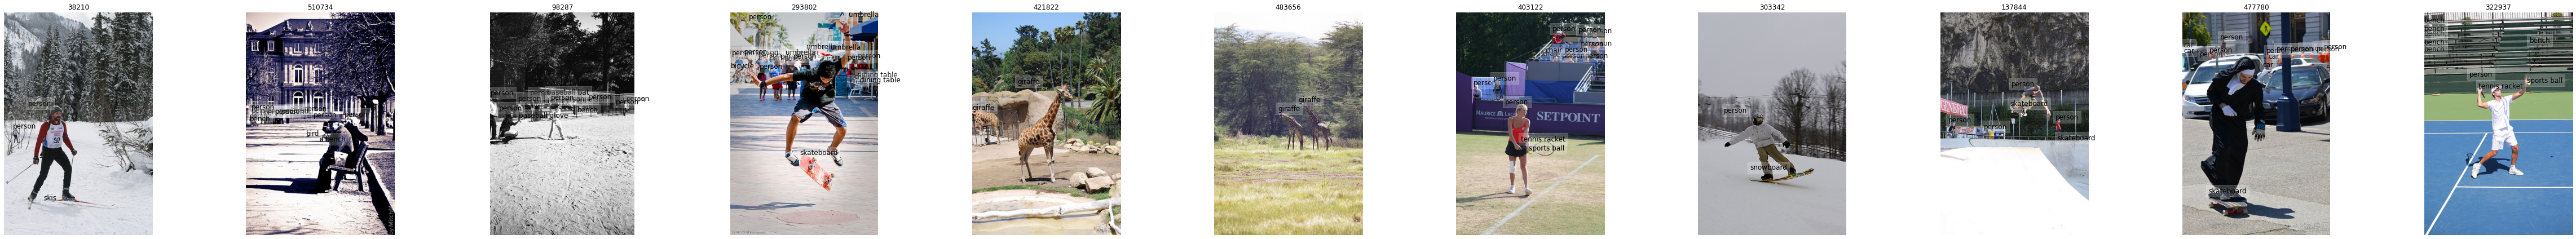

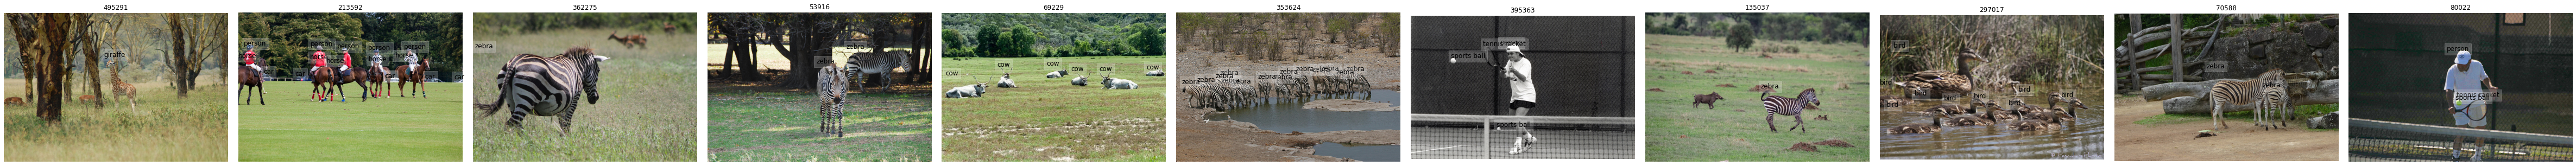

In [ ]:
for j in range(I.shape[0]):
  l = []
  for i in range(I.shape[1]):
    l.append(idx2Img[I[j][i]])
  plotter.plot_coco_images([l])


In [ ]:
from operator import itemgetter
def faiss_precision (plotter, faiss_obj, query_embedding, query_idx, idx2coco_map: dict,
                     n_neighbors: int = 11, at_k: int = 4, category=True):
    

    D, indices = faiss_obj.search(query_embedding, n_neighbors)
    #closest_at_k = closest[1: at_k + 1]
    #indices = I[0][1:k+1]
    retrieved_indices = indices[0][1:at_k+1] # top 4 image locations

    if category == True:
        ground_truth = plotter.category_labels[query_idx]
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.category_labels)
    else:
        ground_truth = plotter.supercategory_labels[query_idx]
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.supercategory_labels)
    
    precision = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / (n_neighbors-1)
    return precision

def avg_precision(plotter, faiss, em_np, query_idxs, idx2Img, n_neighbors, k, category=True):
    avg_precision = 0
    for idx in query_idxs:
      embed = em_np[idx]
      embed = np.reshape(embed, (1,25088))
      avg_precision += faiss_precision(plotter, faiss, embed, idx, idx2Img, n_neighbors, k, category)
    avg_precision = avg_precision / len(query_idxs)
    return avg_precision

In [ ]:
category_precision = avg_precision(plotter, index, em_np, query_idxs, idx2Img, 11, k=4, category=False)
supercategory_precision = avg_precision(plotter, index, em_np, query_idxs, idx2Img, 11, k=4, category=True)

print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 20.0%
Supercategory-level precision: 10.0%


In [ ]:
def faiss_recall(plotter, faiss_obj, query_embedding, query_idx, idx2coco_map: dict,
                     n_neighbors: int = 11, at_k: int = 4, category=True):
    """
    :plotter: plotter object from plot_utils.py
    :idx: embedding nidex
    :nbrs: for nearest neighbors object
    :category: if True then calculate on categories, otherwise calcuate at supercategory
    """

    D, indices = faiss_obj.search(query_embedding, n_neighbors)
    #closest_at_k = closest[1: at_k + 1]
    retrieved_indices = indices[0][1:at_k+1] # top 4 image locations
    
    if category == True:
        ground_truth = plotter.category_labels[query_idx]
        total_retrieved_labels = itemgetter(*indices[0][1:])(plotter.category_labels)
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.category_labels)
    else:
        ground_truth = plotter.supercategory_labels[query_idx]
        total_retrieved_labels = itemgetter(*indices[0][1:])(plotter.supercategory_labels)
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.supercategory_labels)
    relevant_labels = [i for i in total_retrieved_labels if i == ground_truth]
    recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)
    if len(relevant_labels) == 0:
        return 0
    else:
        return recall

def avg_recall(plotter, faiss, em_np, query_idxs, idx2Img, n_neighbors, k, category=True):
    avg_recall = 0
    for idx in query_idxs:
        embed = em_np[idx]
        embed = np.reshape(embed, (1,25088))
        avg_recall += faiss_recall(plotter, faiss, embed, idx, idx2Img, n_neighbors, k, category)

    avg_recall = avg_recall / len(query_idxs)
    return avg_recall

In [ ]:
category_recall = avg_recall(plotter, index, em_np, query_idxs, idx2Img, 11, k=4, category=False)
supercategory_recall = avg_recall(plotter, index, em_np, query_idxs, idx2Img, 11, k=4, category=True)

print("Category-level recall: {}%".format(round(category_recall*100, 2)))
print("Supercategory-level recall: {}%".format(round(supercategory_recall*100, 2)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Category-level recall: 28.57%
Supercategory-level recall: 14.29%
